<a href="https://colab.research.google.com/github/BinarPlatinumChallenge/Sentiment-Analysis/blob/main/NN-LSTM_collabs/3_LSTM_done_fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PREPARE DATASET**

## **Download Dataset**

Raw data traning can be downloaded with this [link](https://drive.google.com/file/d/1RCHGfn9JJyyReAh8PIIoF8Ch0H3miP0u/view)

Raw data set hates speech, file kamus alay dan stopwords can be downloaded in this [link](https://drive.google.com/drive/folders/1qm50pKAnzGGw9gtk--lmwR758aZOVish) 

In [ ]:
# mounting to google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Libraries to read and analyze data frame
# Read raw dataset used for training the model from google drive

import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/CHALLENGE_PLATINUM/train_preprocess.tsv.txt', delimiter='\t', header=0, names=['tweet','sentimen'])

# Eliminated null and duplicated data
df = df.dropna()
df = df.drop_duplicates(ignore_index=True)

## **Text Normalization/Cleansing**

In [ ]:
# Install libraries for stopwords

!pip install nltk
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 KB 7.7 MB/s eta 0:00:00


In [ ]:
# import library to handle stopwords using NLTK

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words=(stopwords.words('indonesian'))

# import library to handle stopwords using sastrawi

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
stop_factory = StopWordRemoverFactory()
sastrawi_stop_words = stop_factory.get_stop_words()
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# read data "stopwordbahasa.csv"
stopword_dict = pd.read_csv('/content/drive/MyDrive/CHALLENGE_PLATINUM/stopwordbahasa.csv', header=None, names=['stopword'], encoding='latin-1')

# add {'ya','yg','ga','yuk','dah','sih','gue','nya','nih'} in stopwords dict set
# merge stopwords dictionary from NLTK, sastrawi, and raw file "stopwordbahasa.csv"
stopword_dict = list(stopword_dict['stopword']) + sastrawi_stop_words + stop_words + ['ya','yg','ga','yuk','dah','sih','gue','nya','nih']
stopword_dict = list(dict.fromkeys(stopword_dict))

# eliminated word "tidak" from stopwords dict set to avoid changing the meaning of the sentence 
stopword_dict = filter(lambda word: word !='tidak', stopword_dict)
stopword_dict = list(stopword_dict)
print(len(stopword_dict))

781


In [ ]:
# import library to handle stopwords using NLTK

import re
def lowercase(text): #1
  text = text.strip() 
  return text.lower()

def remove_unnecessary_char(text): #2
  text = re.sub('\\+n', ' ', text) # remove every new line
  text = re.sub('\n'," ",text) # remove every single new line
  text = re.sub('\\+', ' ', text) # remomove unessessary character
  text = re.sub(r'\brt\b','', text) # r'\b...\b to remove certain word, only at the beginning or end of the word for 'rt' 
  text = re.sub(r'\buser\b','', text) # r'\b...\b to remove certain word, only at the beginning or end of the word for 'user'
  text = re.sub(r'\burl\b','', text)
  text = re.sub(r'\bnurl\b','', text)
  text = re.sub('&lt;/?[a-z]+&gt;', '', text) #remove special characters
  text = re.sub('&amp', '', text) #remove ampersand character
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # remomove unessessary character 
  text = re.sub(':', ' ', text) # remomove special character 
  text = re.sub(';', ' ', text) 
  text = re.sub('  +', ' ', text) 
  text = re.sub(r'pic.twitter.com.[\w]+', '', text) # remomove unessessary character 
  text = re.sub(r'[^\x00-\x7F]+',' ', text)  
  text = re.sub(r'‚Ä¶', '', text)  
  to_delete = ['hypertext', 'transfer', 'protocol', 'over', 'secure', 'socket', 'layer', 'dtype', 'tweet', 'name', 'object'
                 ,'twitter','com', 'pic'] # delete another unessessary words
  for word in to_delete: 
      text = re.sub(word,'', text) # remove extra space
      text = re.sub(word.upper(),' ',text)
  return text

def remove_nonaplhanumeric(text): #3
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

def remove_emoticon_byte(text): #4
    text = text.replace("\\", " ")
    text = re.sub(r'\bx..', ' ', text)
    text = re.sub(' n ', ' ', text)
    return text

def remove_early_space(text): #5
    if text[0] == ' ':
        return text[1:]
    else:
        return text

def remove_number(text): #6
    text = ''.join([i for i in text if not i.isdigit()])
    text = re.sub('  +', ' ', text)
    text = text.strip()
    return text

# handle special word "tidak" --> "tidak_" to avoid changing the meaning of the sentance

def handleTidak(text): #7
    words = text.split(' ')
    text = ' '.join(['tidak_' if words[i] == 'tidak' else words[i] for i in range(len(words))])
    text = text.strip()
    text = text.replace('tidak_ ','tidak_')
    return text


In [ ]:
# text normalization 

def normalize_alay(text): #8
    alay_dict = pd.read_csv('/content/drive/MyDrive/CHALLENGE_PLATINUM/new_kamusalay.csv', names=['original', 'replacement'], encoding='latin-1')
    alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
    normalize_text = ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])
    return normalize_text

def remove_stopword(text): #9
    text = ' '.join(['' if word in stopword_dict else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text)
    text = text.strip()
    return text

def stemming(text): #10
    return stemmer.stem(text)

In [ ]:
# text cleansing process

def cleanse_text(text):
    text = lowercase(text) #1
    text = remove_unnecessary_char(text) #2
    text = remove_nonaplhanumeric(text) #3
    text = remove_emoticon_byte(text) #4
    text = remove_early_space(text) #5
    text = remove_number(text) #6
    text = normalize_alay(text) #8
    text = remove_stopword(text) #9
    text = stemming(text) #10
    text = handleTidak(text) #7
    return text

In [ ]:
# check cleansing result

text = '- disaat semua cowok berusaha melacak perhatian gue. loe lantas remehkan perhatian yg gue kasih khusus ke elo. basic elo cowok bego ! ! !'
cleaned_text = cleanse_text(text)
cleaned_text

'cowok usaha lacak perhati lantas remeh perhati kasih khusus basic cowok bego'

In [ ]:
# applied data cleansing process into dataframe

df['cleaned_tweet'] = df.tweet.apply(cleanse_text)

## Cheking Cleansing Result

In [ ]:
# checking the frequency of words

new_df = df.cleaned_tweet.str.split(expand=True).stack().value_counts().reset_index()
new_df.columns = ['Word', 'Frequency'] 
new_df.head(10)

,Word,Frequency
0,makan,6458
1,enak,3684
2,harga,2001
3,bandung,1746
4,menu,1735
5,banget,1511
6,restoran,1300
7,layan,1260
8,pilih,1260
9,jalan,1013


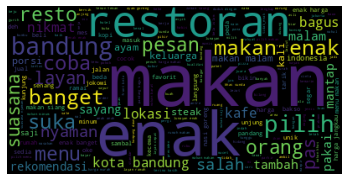

In [ ]:
# checking the frequency of words using matplotlib and WordCloud

import matplotlib.pyplot as plt
from wordcloud import WordCloud
text = ' '.join(df['cleaned_tweet'])
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
# save clean dataset to google drive

df.to_csv('/content/drive/MyDrive/CHALLENGE_PLATINUM/train_cleaned_preprocess.csv', header = True)
df.head()

,tweet,sentimen,cleaned_tweet
0,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus k mmbri hujjah partai diwlh ...
1,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis jalan sumatra bandung nyaman ...
2,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia unboxing paket barang bagus tet...
3,duh . jadi mahasiswa jangan sombong dong . kas...,negative,aduh mahasiswa sombong kasih kartu kuning ajar...
4,"makanan beragam , harga makanan di food stall ...",positive,makan agam harga makan food stall kasir suasan...


# **Feature Extraction**

To speed up data normalization process, we can open the data file that has been cleaned by the following [link](https://drive.google.com/file/d/13psC1vvL2UyEc0cuQfC-O7lnV3zlIBcD/view?usp=sharing)

In [ ]:
# Read data yang sudah di cleansing
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/CHALLENGE_PLATINUM/train_cleaned_preprocess.csv', header=0, names=['tweet','sentimen', 'cleaned_tweet'])
df = df.dropna()
df = df.drop_duplicates(ignore_index=True)
df.head()

,tweet,sentimen,cleaned_tweet
0,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus k mmbri hujjah partai diwlh ...
1,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis jalan sumatra bandung nyaman ...
2,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia unboxing paket barang bagus tet...
3,duh . jadi mahasiswa jangan sombong dong . kas...,negative,aduh mahasiswa sombong kasih kartu kuning ajar...
4,"makanan beragam , harga makanan di food stall ...",positive,makan agam harga makan food stall kasir suasan...


In [ ]:
# Convert a given array to an ordinary list with the same items, elements, or values

neg = df.loc[df['sentimen'] == 'negative'].cleaned_tweet.tolist()
neu = df.loc[df['sentimen'] == 'neutral'].cleaned_tweet.tolist()
pos = df.loc[df['sentimen'] == 'positive'].cleaned_tweet.tolist()

neg_label = df.loc[df['sentimen'] == 'negative'].sentimen.tolist()
neu_label = df.loc[df['sentimen'] == 'neutral'].sentimen.tolist()
pos_label = df.loc[df['sentimen'] == 'positive'].sentimen.tolist()

total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label
print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6380, Neu: 1138, Neg: 3411
Total data: 10929


In [ ]:
# Library pickle for saving data and process
# Tokenizer and pad_squences from library tensorflow for feature extraction process
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 60000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)

# saving pickle file in google drive 
with open('/content/drive/MyDrive/CHALLENGE_PLATINUM/Pickle_resource/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle) # protocol=pickle.HIGHEST_PROTOCOL hapus
    print("tokenizer.pickle has created!")

# tokenizer module definition
X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

# pad squenseces module definition
X = pad_sequences(X)

# saving pickle file in google drive 
with open('/content/drive/MyDrive/CHALLENGE_PLATINUM/Pickle_resource/x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle) # hapus
    print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [ ]:
# input data label to Y variable

Y = pd.get_dummies(labels)
Y = Y.values

# saving pickle file in google drive 
with open('/content/drive/MyDrive/CHALLENGE_PLATINUM/Pickle_resource/y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


In [ ]:
from sklearn.model_selection import train_test_split

# variable x = saving data text 
file = open("/content/drive/MyDrive/CHALLENGE_PLATINUM/Pickle_resource/x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

# variable y = saving data label
file = open("/content/drive/MyDrive/CHALLENGE_PLATINUM/Pickle_resource/y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

# splitting dataset to data train (80%); and data test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# **DATA TRAININGM : LSTM Method**

In [ ]:
# import numpy and tensorflow framework

import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K


In [ ]:
# define input layer and unit layer

def createModel(embed_dim = 32, units = 32):
  model = Sequential()
  model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
  model.add(LSTM(units, dropout=0.2)) # Feature dropuot to minimize overfitting
  model.add(Dense(3,activation='softmax')) # Softmax activation
  model.compile(loss = 'binary_crossentropy', optimizer='RMSprop',metrics = ['accuracy'])
  print(model.summary())

  optimizer = optimizers.RMSprop(learning_rate = 0.001)
  model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

  # Earlystopping
  es = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)
  history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test), verbose=1, callbacks=[es])
  return model, history

model, history = createModel()


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 54, 32)            1920000   
                                                                 
 lstm_26 (LSTM)              (None, 32)                8320      
                                                                 
 dense_26 (Dense)            (None, 3)                 99        
                                                                 
Total params: 1,928,419
Trainable params: 1,928,419
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
69/69 [==============================] - 8s 77ms/step - loss: 0.7781 - accuracy: 0.6469 - val_loss: 0.6003 - val_accuracy: 0.7653
Epoch 2/10
69/69 [==============================] - 6s 86ms/step - loss: 0.5396 - accuracy: 0.7794 - val_loss: 0.5130 - val_accuracy: 0.7964
Epoch 3/10
69/69 [==

## Model training report and evaluation

In [ ]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 [==============================] - 2s 11ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.81      0.78      0.79       694
           1       0.65      0.77      0.70       231
           2       0.90      0.90      0.90      1261

    accuracy                           0.84      2186
   macro avg       0.79      0.81      0.80      2186
weighted avg       0.85      0.84      0.85      2186



# CROSS VALIDATION

In [ ]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=0,shuffle=True)

accuracies = []

y = Y

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]

    model, history = createModel()

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only    
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 54, 32)            1920000   
                                                                 
 lstm_27 (LSTM)              (None, 32)                8320      
                                                                 
 dense_27 (Dense)            (None, 3)                 99        
                                                                 
Total params: 1,928,419
Trainable params: 1,928,419
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
69/69 [==============================] - 12s 79ms/step - loss: 0.8264 - accuracy: 0.6413 - val_loss: 0.6771 - val_accuracy: 0.7077
Epoch 2/10
69/69 [==============================] - 5s 73ms/step - loss: 0.5817 - accuracy: 0.7686 - val_loss: 0.5457 - val_accuracy: 0.7845
Epoch 3/10
69/69 [=

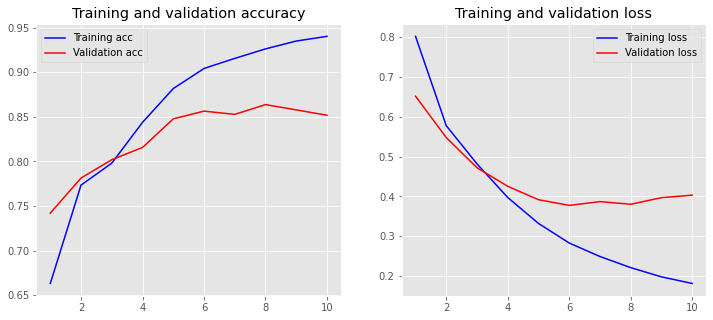

In [ ]:
# history.history
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [ ]:
model.save('/content/drive/MyDrive/CHALLENGE_PLATINUM/Pickle_resource/model.h5')
print("Model has created!")

Model has created!


In [ ]:
import re 
from keras.models import load_model

input_text = """
disaat semua cowok berusaha melacak perhatian gue. loe lantas remehkan perhatian yg gue kasih khusus ke elo. basic elo cowok bego ! ! !'
"""

sentiment = ['negative', 'neutral', 'positive']

text = [cleanse_text(input_text)] 
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('/content/drive/MyDrive/CHALLENGE_PLATINUM/Pickle_resource/model.h5')
prediction = model.predict(guess)
print(prediction)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 1s 1s/step
[[0.19857551 0.77900046 0.02242395]]
Text:  cowok usaha lacak perhati lantas remeh perhati kasih khusus basic cowok bego
Sentiment:  neutral
